In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

### The code below is based on two repositories:

- https://github.com/Facebookresearch/deepsdf
- https://arxiv.org/pdf/1901.05103.pdf
- https://github.com/Oktosha/DeepSDF-explained

In [11]:
class Geometry:
    EPS = 1e-12

    def distance_from_segment_to_point(a, b, p):
        ans = min(np.linalg.norm(a - p), np.linalg.norm(b - p))
        if (np.linalg.norm(a - b) > Geometry.EPS 
            and np.dot(p - a, b - a) > Geometry.EPS 
            and np.dot(p - b, a - b) > Geometry.EPS):
            ans = abs(np.cross(p - a, b - a) / np.linalg.norm(b - a))
        return ans


class Circle:
    
    def __init__(self, c, r):
        self.c = c
        self.r = r
    
    def sdf(self, p):
        return np.linalg.norm(p - self.c) - self.r
    
    
class Polygon:
    
    def __init__(self, v):
        self.v = v
    
    def sdf(self, p):
        return -self.distance(p) if self.point_is_inside(p) else self.distance(p)
    
    def point_is_inside(self, p):
        angle_sum = 0
        L = len(self.v)
        for i in range(L):
            a = self.v[i]
            b = self.v[(i + 1) % L]
            angle_sum += np.arctan2(np.cross(a - p, b - p), np.dot(a - p, b - p))
        return abs(angle_sum) > 1
            
    def distance(self, p):
        ans = Geometry.distance_from_segment_to_point(self.v[-1], self.v[0], p)
        for i in range(len(self.v) - 1):
            ans = min(ans, Geometry.distance_from_segment_to_point(self.v[i], self.v[i + 1], p))
        return ans

In [3]:
def plot_sdf(sdf_func):
    COORDINATES_LINSPACE = np.linspace(-4, 4, 100)
    y, x = np.meshgrid(COORDINATES_LINSPACE, COORDINATES_LINSPACE)
    z = np.float_([[sdf_func(np.float_([x_, y_])) 
                    for y_ in  COORDINATES_LINSPACE] 
                    for x_ in COORDINATES_LINSPACE])
    z = z[:-1, :-1]
    z_min, z_max = -np.abs(z).max(), np.abs(z).max()
    fig, ax = plt.subplots(figsize=(6, 6))
    c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
    plt.axis([x.min(), x.max(), y.min(), y.max()])

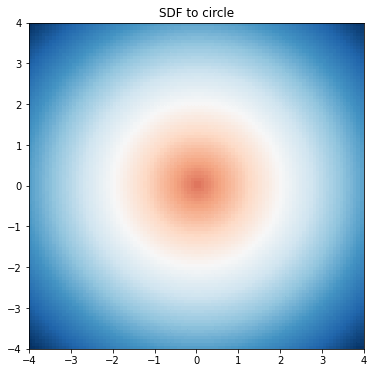

In [4]:
# круг с центром в начале координат и радиусом 2
circle = Circle(np.float_([0, 0]), 2)
plot_sdf(circle.sdf)
plt.title("SDF to circle")
plt.show()

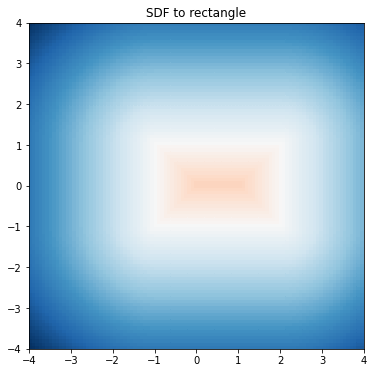

In [5]:
rectangle = Polygon(np.float_([[-1, -1], [-1, 1], [2, 1], [2, -1]]))
plot_sdf(rectangle.sdf)
plt.title("SDF to rectangle")
plt.show()

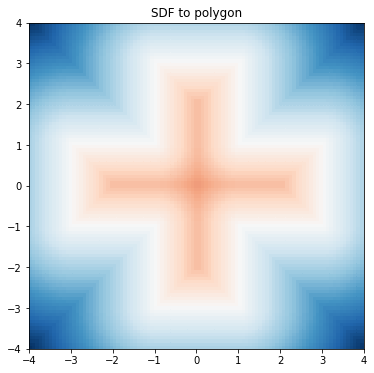

In [6]:
polygon = Polygon(np.float_([
    [1, 3], [1, 1], [3, 1], [3, -1], [1, -1], 
    [1, -3], [-1, -3], [-1, -1], [-3, -1], 
    [-3, 1], [-1, 1], [-1, 3]
]))
plot_sdf(polygon.sdf)
plt.title("SDF to polygon")
plt.show()

In [7]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.Tensor(x)
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


# Train for circle

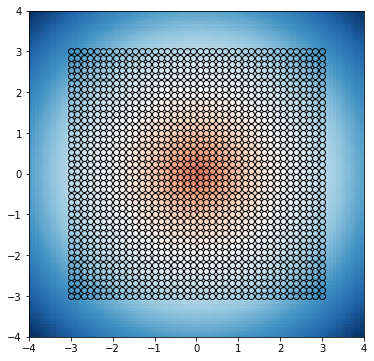

In [9]:
points_train = np.float_([[x_, y_] 
                    for y_ in  np.linspace(-3, 3, 40) 
                    for x_ in np.linspace(-3, 3, 40)])
sdf_train = np.float_(list(map(circle.sdf, points_train)))

plot_sdf(circle.sdf)
plt.scatter(points_train[:,0], points_train[:,1], color=(1, 1, 1, 0), edgecolor="#000000")

train_ds = TensorDataset(torch.Tensor(points_train), torch.Tensor(sdf_train))
train_dl = DataLoader(train_ds, shuffle=True, batch_size=len(train_ds))

In [10]:
points_train.shape, sdf_train.shape

((1600, 2), (1600,))

Epoch: 999 Loss: 0.297768771648407


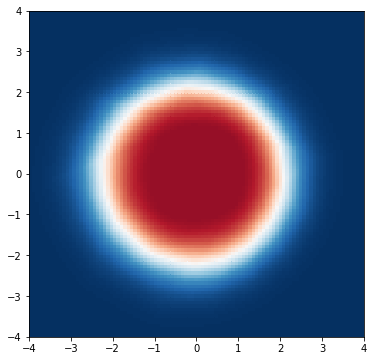

In [12]:
net = Net()
epochs = 1000
opt = optim.SGD(net.parameters(), lr=1)
for epoch in range(epochs):
    net.train()
    total_loss = 0
    for points_b, sdfs_b in train_dl:
        pred = net(points_b)
        pred = pred.squeeze()
        loss = F.l1_loss(pred, sdfs_b)
        total_loss += loss
        loss.backward()
        opt.step()
        opt.zero_grad()

print("Epoch:", epoch, "Loss:", total_loss.item())
plot_sdf(net.forward)
plt.show()

# Train for rectangle

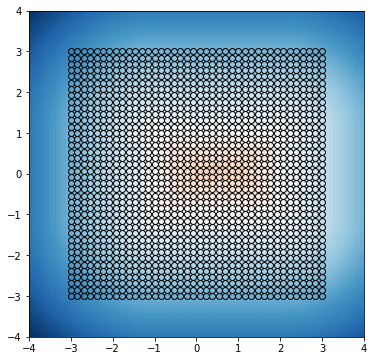

In [13]:
points_train = np.float_([[x_, y_] 
                    for y_ in  np.linspace(-3, 3, 40) 
                    for x_ in np.linspace(-3, 3, 40)])
sdf_train = np.float_(list(map(rectangle.sdf, points_train)))

plot_sdf(rectangle.sdf)
plt.scatter(points_train[:,0], points_train[:,1], color=(1, 1, 1, 0), edgecolor="#000000")

train_ds = TensorDataset(torch.Tensor(points_train), torch.Tensor(sdf_train))
train_dl = DataLoader(train_ds, shuffle=True, batch_size=len(train_ds))

Epoch: 1999 Loss: 0.36965659260749817


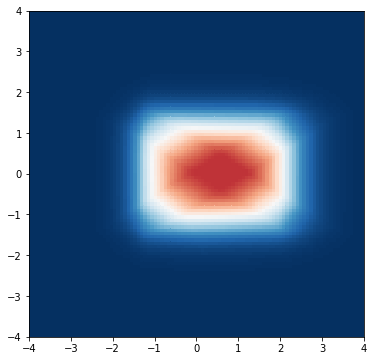

In [15]:
net = Net()
epochs = 2000
delta = 10
opt = optim.SGD(net.parameters(), lr=1)
for epoch in range(epochs):
    net.train()
    total_loss = 0
    for points_b, sdfs_b in train_dl:
        pred = net(points_b)
        pred = pred.squeeze()
        loss = F.l1_loss(pred, sdfs_b)
        total_loss += loss
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print("Epoch:", epoch, "Loss:", total_loss.item())
plot_sdf(net.forward)
plt.show()

# Train for polygon

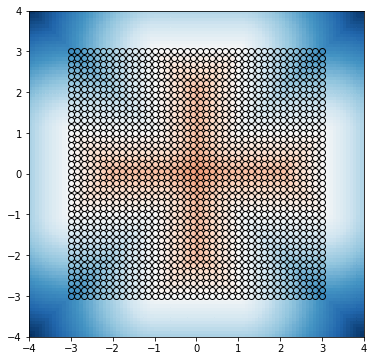

In [16]:
points_train = np.float_([[x_, y_] 
                    for y_ in  np.linspace(-3, 3, 40) 
                    for x_ in np.linspace(-3, 3, 40)])
sdf_train = np.float_(list(map(polygon.sdf, points_train)))

plot_sdf(polygon.sdf)
plt.scatter(points_train[:,0], points_train[:,1], color=(1, 1, 1, 0), edgecolor="#000000")

train_ds = TensorDataset(torch.Tensor(points_train), torch.Tensor(sdf_train))
train_dl = DataLoader(train_ds, shuffle=True, batch_size=len(train_ds))

Epoch: 4999 Loss: 0.2928365468978882


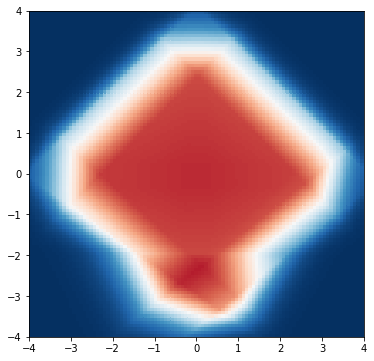

In [17]:
net = Net()
epochs = 5000
delta = 10
opt = optim.SGD(net.parameters(), lr=1)
for epoch in range(epochs):
    net.train()
    total_loss = 0
    for points_b, sdfs_b in train_dl:
        pred = net(points_b)
        pred = pred.squeeze()
        loss = F.l1_loss(pred, sdfs_b)
        total_loss += loss
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print("Epoch:", epoch, "Loss:", total_loss.item())
plot_sdf(net.forward)
plt.show()

### TODO:
- fix sdf func for Polygon